In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [2]:
import pathlib
data_dir = "images"
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

WindowsPath('images')

In [7]:
batch_size = 32
img_height = int(3888*0.2)
img_width = int(5184*0.2)

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 765 files belonging to 5 classes.
Using 612 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 765 files belonging to 5 classes.
Using 153 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['brown_rust', 'healthy', 'rhynhosporium', 'septoria', 'yellow_rust']


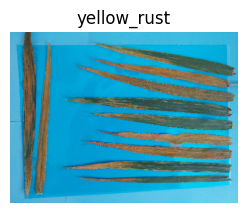

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 388, 518, 3)
(32,)


In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
20/20 [==============================] - 97s 4s/step - loss: 2.7667 - accuracy: 0.3791 - val_loss: 1.1255 - val_accuracy: 0.5229
Epoch 2/3
20/20 [==============================] - 53s 3s/step - loss: 0.8516 - accuracy: 0.6716 - val_loss: 0.7319 - val_accuracy: 0.7386
Epoch 3/3
20/20 [==============================] - 51s 3s/step - loss: 0.4583 - accuracy: 0.8431 - val_loss: 0.4407 - val_accuracy: 0.8627


In [ ]:
# Epoch 1/3
# 20/20 [==============================] - 97s 4s/step - loss: 2.7667 - accuracy: 0.3791 - val_loss: 1.1255 - val_accuracy: 0.5229
# Epoch 2/3
# 20/20 [==============================] - 53s 3s/step - loss: 0.8516 - accuracy: 0.6716 - val_loss: 0.7319 - val_accuracy: 0.7386
# Epoch 3/3
# 20/20 [==============================] - 51s 3s/step - loss: 0.4583 - accuracy: 0.8431 - val_loss: 0.4407 - val_accuracy: 0.8627

In [22]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

765


In [23]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [24]:
for f in list_ds.take(5):
    print(f.numpy())

b'images\\septoria\\20210706_194947.jpg'
b'images\\septoria\\20210706_193317.jpg'
b'images\\rhynhosporium\\20210608_124155.jpg'
b'images\\septoria\\20210706_191208.jpg'
b'images\\rhynhosporium\\20210608_123449.jpg'


In [25]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['brown_rust' 'healthy' 'rhynhosporium' 'septoria' 'yellow_rust']


In [26]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [27]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

612
153


In [28]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [29]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [30]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [31]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [32]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (388, 518, 3)
Label:  2


In [33]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

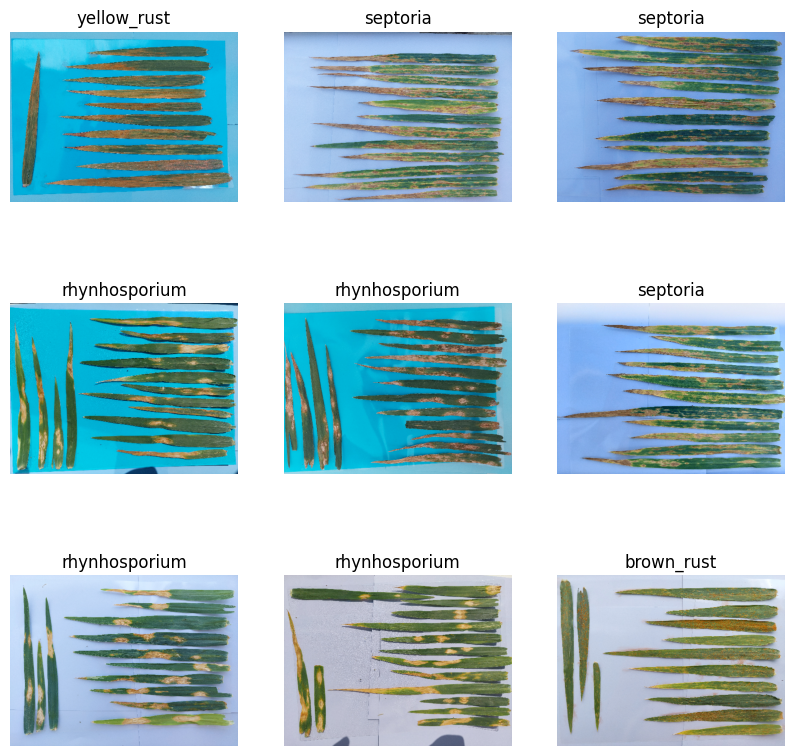

In [34]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i] 
    plt.title(class_names[label])
    plt.axis("off")

In [35]:
# model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=3
# )

Epoch 1/3
20/20 [==============================] - 59s 3s/step - loss: 0.3143 - accuracy: 0.8856 - val_loss: 0.2583 - val_accuracy: 0.8889
Epoch 2/3
20/20 [==============================] - 50s 2s/step - loss: 0.1750 - accuracy: 0.9461 - val_loss: 0.2939 - val_accuracy: 0.8824
Epoch 3/3
20/20 [==============================] - 49s 2s/step - loss: 0.0611 - accuracy: 0.9902 - val_loss: 0.1902 - val_accuracy: 0.9412


1/1 [==============================] - 0s 500ms/step


(-0.5, 517.5, 387.5, -0.5)

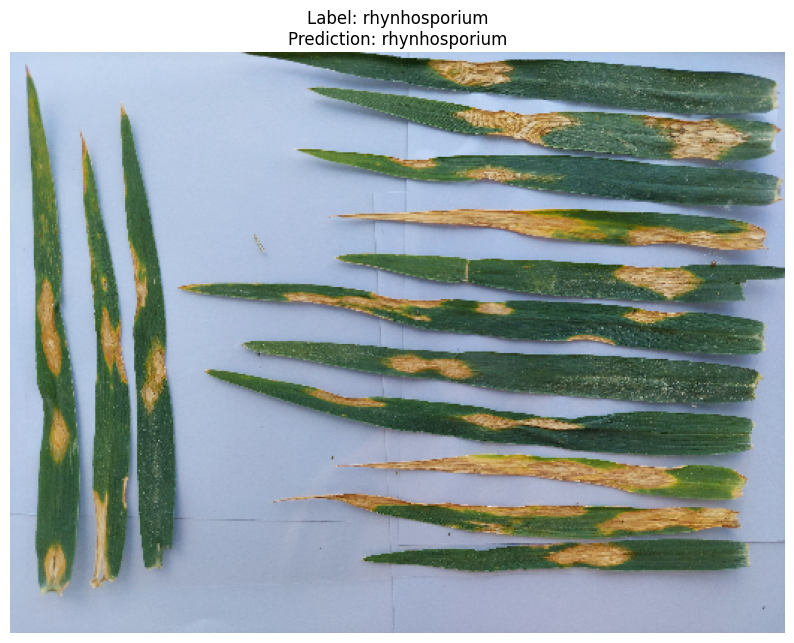

In [67]:
import random
image_batch, label_batch = next(iter(train_ds))
rand = random.choice(range(batch_size))
rand


plt.figure(figsize=(10, 10))

plt.imshow(image_batch[rand].numpy().astype("uint8"))
label = label_batch[rand]
prediction = class_names[np.argmax(model.predict(image_batch)[rand])]
plt.title("Label: " + class_names[label] + "\n" + "Prediction: " + prediction)
plt.axis("off")

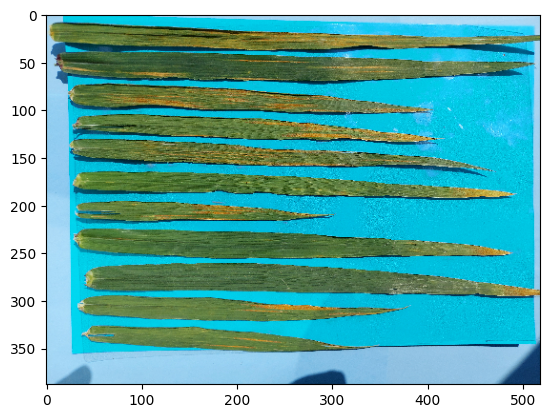

In [ ]:
# brudnopis

In [43]:
model.predict(image_batch)[0]

1/1 [==============================] - 0s 484ms/step


<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([4, 3, 3, 2, 2, 3, 2, 2, 0, 3, 4, 3, 3, 4, 0, 0, 0, 4, 4, 4, 2, 0,
       0, 3, 3, 2, 3, 0, 4, 0, 3, 4], dtype=int64)>

In [50]:
class_names[label_batch[0]]

'yellow_rust'

In [47]:
class_names[np.argmax(model.predict(image_batch)[0])]

1/1 [==============================] - 0s 483ms/step


'yellow_rust'

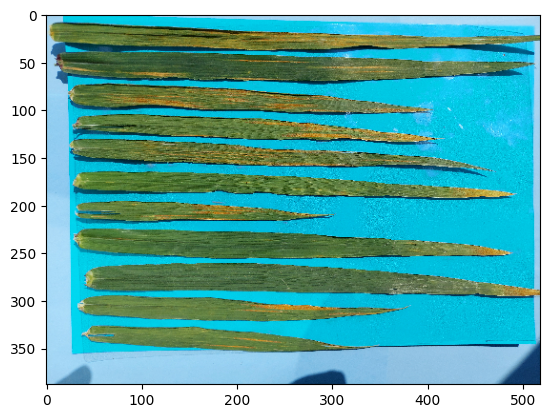

In [66]:
plt.imshow(image_batch[0].numpy().astype("uint8"))